In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

In [3]:
print("\u2022 Using TensorFlow Version:", tf.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.5.0
• GPU Device Found.


In [4]:
!nvidia-smi

Tue Jun  1 06:05:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
DATASET_DIR = '/content/drive/MyDrive/capstone_project/capstone_machine_learning/masked_face_classification/dataset/arranged_dataset' # Change based on dataset dir on your system/device
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
VAL_DIR = os.path.join(DATASET_DIR, 'validation')
TEST_DIR = os.path.join(DATASET_DIR, 'test')
BATCH_SIZE = 32

In [27]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized
        batch_size=BATCH_SIZE,
        class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode='categorical')

Found 10000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.


In [16]:
NUM_CLASSES = train_generator.num_classes
print(NUM_CLASSES)

5


In [17]:
print('Number of classes:', train_generator.num_classes)
print('Class map:', train_generator.class_indices)
print('Auto-shuffle:', train_generator.shuffle, end='\n\n')

print('Number of classes:', val_generator.num_classes)
print('Class map:', val_generator.class_indices)
print('Auto-shuffle:', val_generator.shuffle, end='\n\n')

print('Number of classes:', test_generator.num_classes)
print('Class map:', test_generator.class_indices)
print('Auto-shuffle:', test_generator.shuffle, end='\n\n')

Number of classes: 5
Class map: {'correctly_masked': 0, 'no_mask': 1, 'uncovered_chin': 2, 'uncovered_nose': 3, 'uncovered_nose_and_mouth': 4}
Auto-shuffle: True

Number of classes: 5
Class map: {'correctly_masked': 0, 'no_mask': 1, 'uncovered_chin': 2, 'uncovered_nose': 3, 'uncovered_nose_and_mouth': 4}
Auto-shuffle: False

Number of classes: 5
Class map: {'correctly_masked': 0, 'no_mask': 1, 'uncovered_chin': 2, 'uncovered_nose': 3, 'uncovered_nose_and_mouth': 4}
Auto-shuffle: False



Train samples 3
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


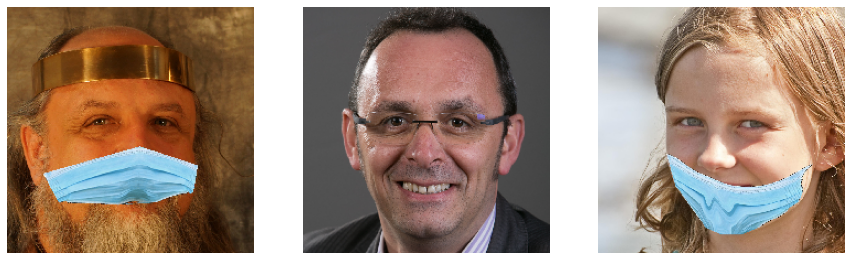

Validation samples 3
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


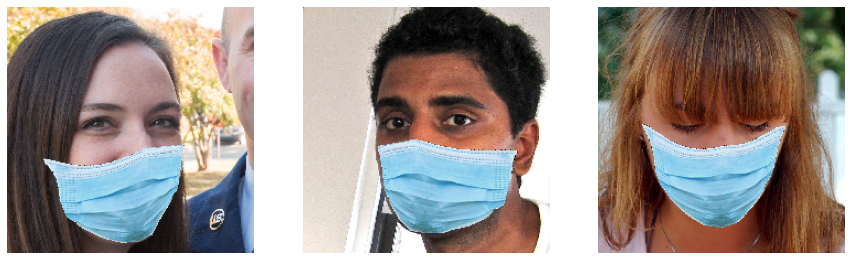

Test samples 3
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


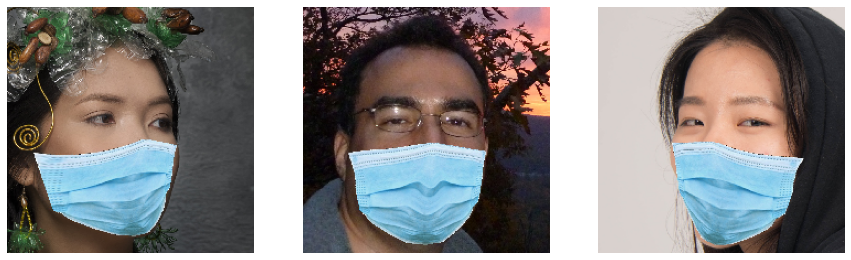

In [10]:
# Sample some images in data generator to display

def display_samples3(generator):
  '''
  Source: https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
  '''
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
  for i in range(3):

    image = next(generator)[0][0]
    print(image.shape)

    ax[i].imshow(image)
    ax[i].axis('off')
  fig.show()
  plt.show()

print('Train samples 3')
display_samples3(train_generator)
print('Validation samples 3')
display_samples3(val_generator)
print('Test samples 3')
display_samples3(test_generator)

In [23]:
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [29]:
inputs = tf.keras.Input(shape=(224,224,3))
#x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(inputs, training=False)
x = tf.keras.layers.Conv2D(1280, 3, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax',  use_bias=True, name='Logits')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 5, 1280)        14746880  
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 5, 1280)        0         
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
Logits (Dense)               (None, 5)                 6405      
Total params: 17,011,269
Trainable params: 14,753,285
Non-trainable params: 2,257,984
_______________________________________

In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
steps_train = np.ceil(train_generator.n/BATCH_SIZE)
steps_val = np.ceil(test_generator.n/BATCH_SIZE)
EPOCH_SIZE = 30

model_path = '/content/drive/MyDrive/capstone_project/capstone_machine_learning/masked_face_classification/model'
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True)
history = model.fit(train_generator,
          steps_per_epoch=steps_train,
          validation_data=test_generator,
          validation_steps=steps_val,
          epochs=EPOCH_SIZE,
          shuffle=True,
          verbose=1,
          callbacks=[es, mc])

Epoch 1/30
313/313 [==============================] - 309s 975ms/step - loss: 0.3826 - accuracy: 0.9434 - val_loss: 0.0865 - val_accuracy: 0.9755

Epoch 00001: val_accuracy improved from -inf to 0.97550, saving model to /content/drive/MyDrive/capstone_project/capstone_machine_learning/masked_face_classification/model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/capstone_project/capstone_machine_learning/masked_face_classification/model/assets
Epoch 2/30
313/313 [==============================] - 1023s 3s/step - loss: 0.0431 - accuracy: 0.9863 - val_loss: 0.0613 - val_accuracy: 0.9790

Epoch 00002: val_accuracy improved from 0.97550 to 0.97900, saving model to /content/drive/MyDrive/capstone_project/capstone_machine_learning/masked_face_classification/model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/capstone_project/capstone_machine_learning/masked_face_classification/model/assets
Epoch 3/30
313/313 [==============================] - 1019s 3s/step - loss: 0.0277 - accuracy: 0.9915 - val_loss: 0.0521 - val_accuracy: 0.9845

Epoch 00003: val_accuracy improved from 0.97900 to 0.98450, saving model to /content/drive/MyDrive/capstone_project/capstone_machine_learning/masked_face_classification/model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/capstone_project/capstone_machine_learning/masked_face_classification/model/assets
Epoch 4/30
313/313 [==============================] - 1057s 3s/step - loss: 0.0118 - accuracy: 0.9965 - val_loss: 0.0538 - val_accuracy: 0.9885

Epoch 00004: val_accuracy improved from 0.98450 to 0.98850, saving model to /content/drive/MyDrive/capstone_project/capstone_machine_learning/masked_face_classification/model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/capstone_project/capstone_machine_learning/masked_face_classification/model/assets
Epoch 5/30
313/313 [==============================] - 1026s 3s/step - loss: 0.0103 - accuracy: 0.9967 - val_loss: 0.0744 - val_accuracy: 0.9800

Epoch 00005: val_accuracy did not improve from 0.98850
Epoch 6/30
313/313 [==============================] - 384s 1s/step - loss: 0.0151 - accuracy: 0.9953 - val_loss: 0.0722 - val_accuracy: 0.9785

Epoch 00006: val_accuracy did not improve from 0.98850
Epoch 7/30
313/313 [==============================] - 302s 967ms/step - loss: 0.0387 - accuracy: 0.9904 - val_loss: 0.0853 - val_accuracy: 0.9820

Epoch 00007: val_accuracy did not improve from 0.98850
Epoch 8/30
313/313 [==============================] - 303s 969ms/step - loss: 0.0138 - accuracy: 0.9954 - val_loss: 0.0970 - val_accuracy: 0.9850

Epoch 00008: val_accuracy did not improve from 0.98850
Epoch 00008: early stopping


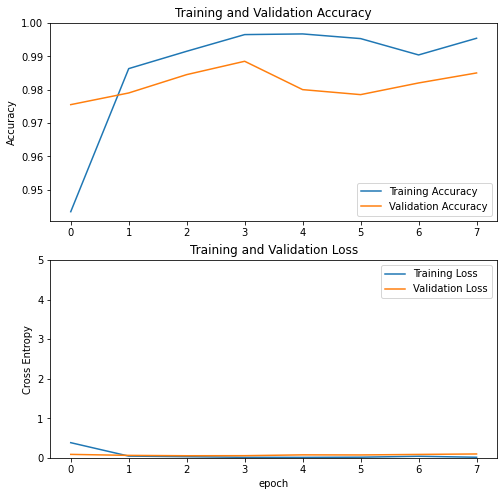

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [34]:
model.evaluate(test_generator)

63/63 [==============================] - 46s 727ms/step - loss: 0.0970 - accuracy: 0.9850


[0.09696534276008606, 0.9850000143051147]

In [35]:
predict = model.predict(test_generator)

In [36]:
predict.argmax(1)[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/capstone_project/capstone_machine_learning/masked_face_classification/notebooks/Saved_Models"
model.save(os.path.join(MODEL_DIR, 'model_mobilenetv2_new_dataset.h5'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Note that due to returning the created figure object, when this funciton is called in a
    notebook the figure willl be printed twice. To prevent this, either append ; to your
    function call, or modify the function by commenting out the return expression.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Note that due to returning the created figure object, when this funciton is called in a notebook
    # the figure willl be printed twice. To prevent this, either append ; to your function call, or
    # modify the function by commenting out this return expression.
    return fig

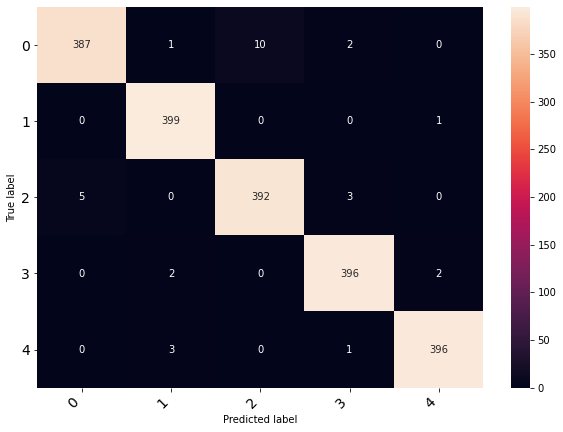

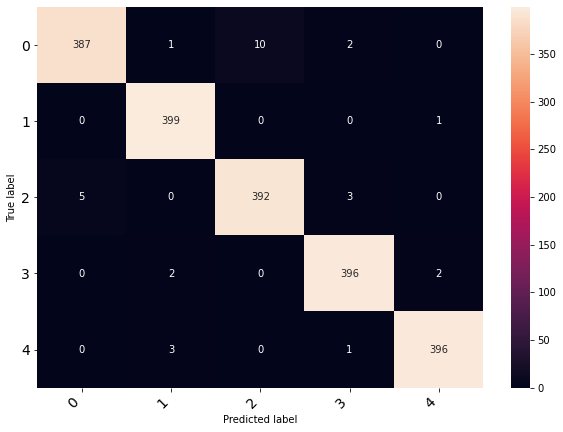

In [38]:
from sklearn.metrics import confusion_matrix
cof_mat = confusion_matrix(test_generator.labels, predict.argmax(1))

print_confusion_matrix(cof_mat, np.unique(test_generator.labels))

In [42]:
best_model = tf.keras.models.load_model('/content/drive/MyDrive/capstone_project/capstone_machine_learning/masked_face_classification/model/')
best_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 5, 1280)        14746880  
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 5, 1280)        0         
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
Logits (Dense)               (None, 5)                 6405      
Total params: 17,011,269
Trainable params: 14,753,285
Non-trainable params: 2,257,984
_______________________________________

In [45]:
best_model.save('/content/drive/MyDrive/capstone_project/capstone_machine_learning/masked_face_classification/notebooks/Saved_Models/MobileNetV2_retrain_best_model.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


**Testing The Model With Random Image**

In [77]:
random_test_dir = '/content/drive/MyDrive/capstone_project/capstone_machine_learning/masked_face_classification/dataset/foto_smartphone'
# All images will be rescaled by 1./255
random_test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
random_test_generator = random_test_datagen.flow_from_directory(
        random_test_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized
        batch_size=1,
        shuffle=False,
        color_mode='rgb',
        class_mode='categorical')


Found 33 images belonging to 5 classes.


In [78]:
print('Number of classes:', random_test_generator.num_classes)
print('Class map:', random_test_generator.class_indices)
print('Auto-shuffle:', random_test_generator.shuffle, end='\n\n')

Number of classes: 5
Class map: {'correctly_masked': 0, 'no_mask': 1, 'uncovered_chin': 2, 'uncovered_nose': 3, 'uncovered_nose_and_mouth': 4}
Auto-shuffle: False



(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


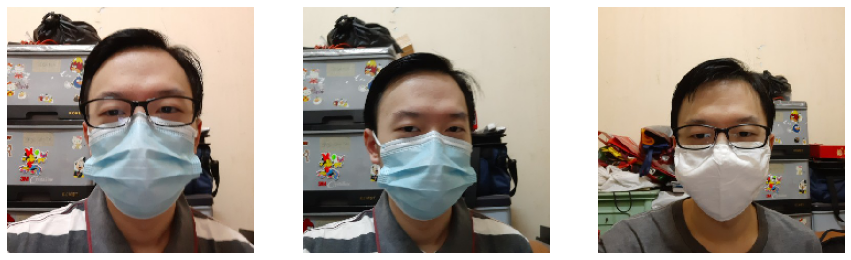

In [79]:
display_samples3(random_test_generator)

In [88]:
random_test_pred = best_model.predict(random_test_generator)

In [89]:
# True Labels
random_test_generator.labels

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

In [90]:
# Prediction Labels
random_test_pred.argmax(1)

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 2, 1, 2, 3, 3, 3,
       0, 0, 1, 3, 3, 3, 3, 3, 3, 1, 1])

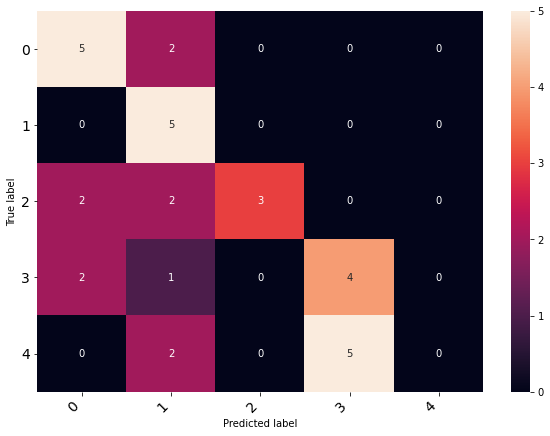

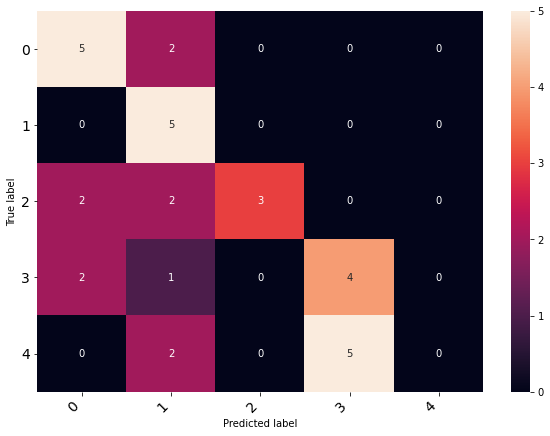

In [91]:
from sklearn.metrics import confusion_matrix
cof_mat2 = confusion_matrix(random_test_generator.labels, random_test_pred.argmax(1))

print_confusion_matrix(cof_mat2, np.unique(random_test_generator.labels))